In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '/home/acy/PCML/projects/project1/train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

DATA_TEST_PATH = '/home/acy/PCML/projects/project1/test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [24]:
from helpers import standardize

def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree."""
    N = x.shape[0]
    D = x.shape[1]
    
    phi = np.zeros((N,D*degree))
    col = 0
    for i in range(1,degree+1):
        for j in range(0,D):
            phi[:,col]=x[:,j]**i
            col=col+1
    return phi

def add_feature(x,f):
    N = x.shape[0]
    D = x.shape[1]
    F = f.shape[1]
    
    res = np.zeros((N,D+F))
    res[:,0:D] = np.copy(x)
    for i in range(0,F):
        res[:,D+i]=f[:,i]
    return res

def clean_data(tX):
    N = tX.shape[0]
    D = tX.shape[1]
    tX_clean = np.copy(np.array(tX))
    for n in range(N):
        for d in range(D):
            if tX_clean[n,d] == -999.0:
                tX_clean[n,d] = 0
    return tX_clean

def feature_process(tX_train, tX_test, poly_degree):
    N_tr = tX_train.shape[0]
    N_te = tX_test.shape[0]
    tX_merged = np.append(tX_train,tX_test,axis=0)
    
    tX_merged_clean = clean_data(tX_merged)
    
    phiX_merged = build_poly(tX_merged_clean, poly_degree)

    phiX_merged = add_feature(phiX_merged,np.sqrt(np.abs(tX_merged_clean)))
    phiX_merged = add_feature(phiX_merged,np.log(np.abs(tX_merged_clean)+0.01))
    # phiX_merged = add_feature(phiX_merged,np.exp(tX_merged_clean))
    phiX_merged = add_feature(phiX_merged,np.tanh(tX_merged_clean))
    # phiX_merged = add_feature(phiX_merged,1/(tX_merged_clean+0.01) )
    # phiX_merged = add_feature(phiX_merged,1/(tX_merged_clean**2+0.01) )
    
    tX_merged_norm, _, _ = standardize(phiX_merged, None, None)
    return tX_merged_norm[0:N_tr,:], tX_merged_norm[N_tr:N_tr+N_te,:]


In [4]:
# tX_train,tX_test_proc = feature_process(tX, tX_test, 3)

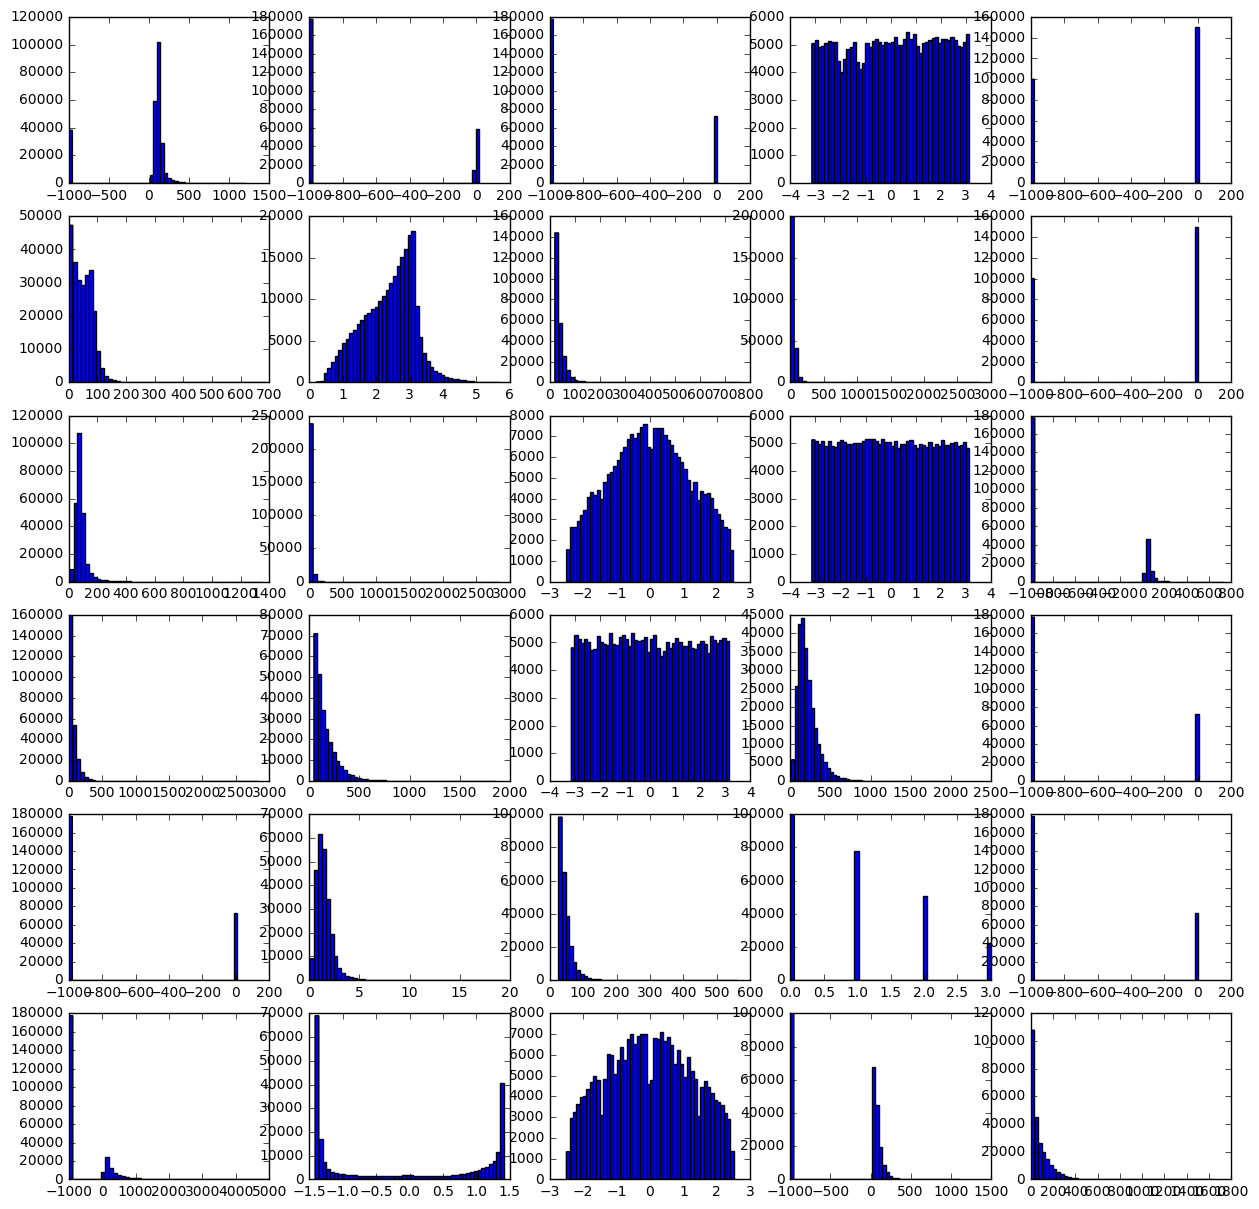

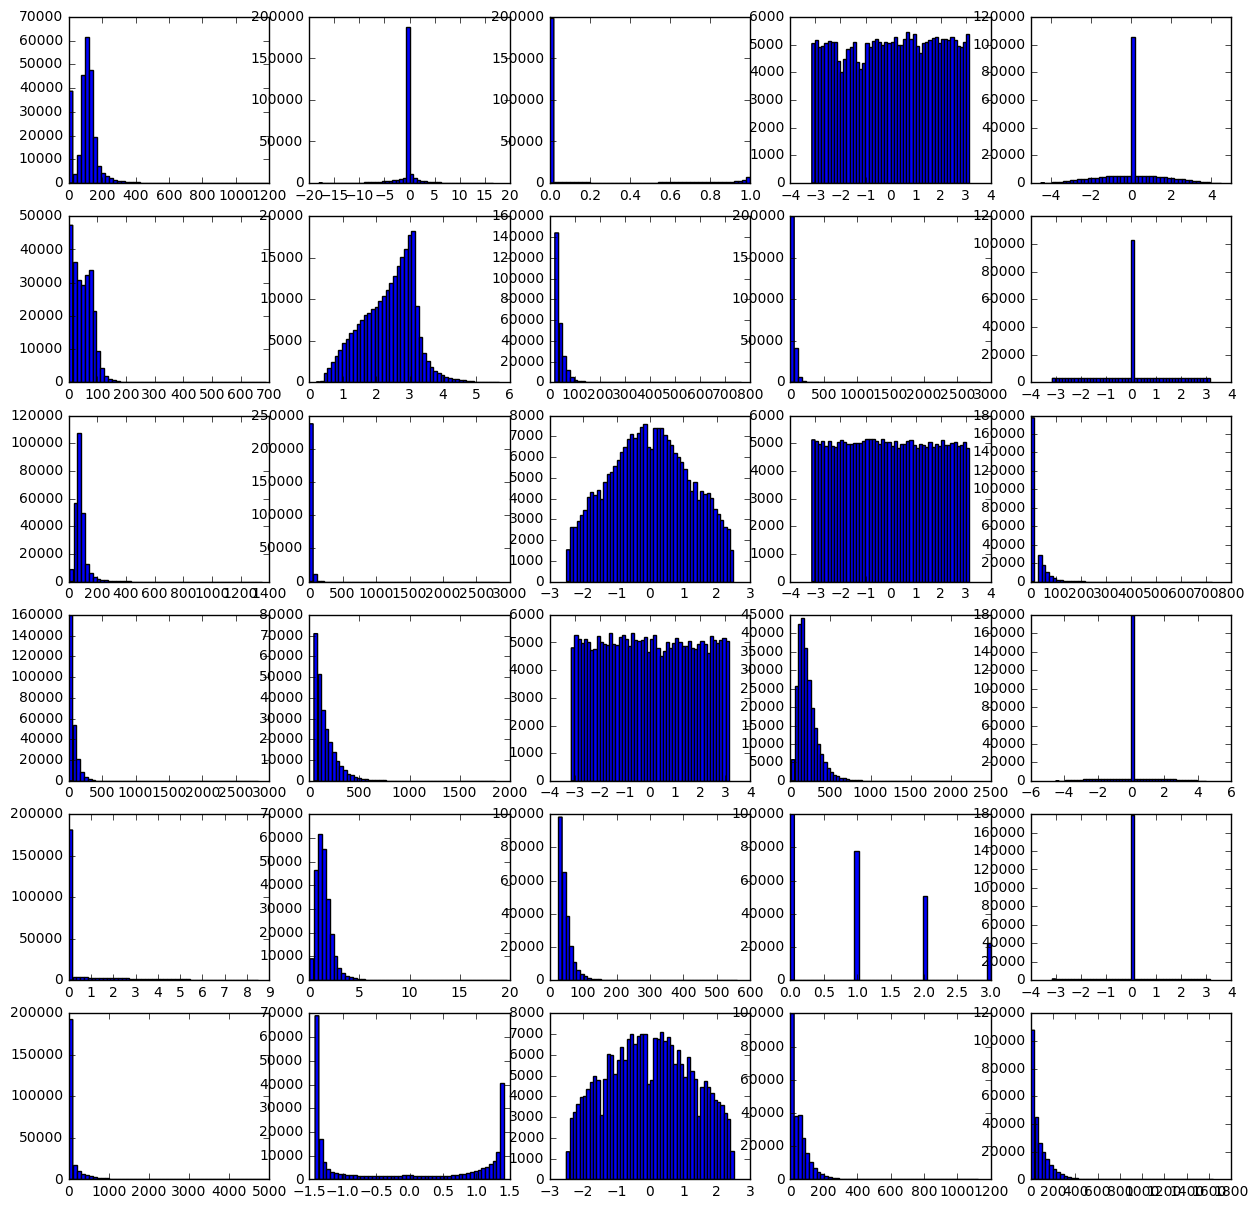

In [5]:
hist_res = 50

tX_clean = clean_data(tX)

f, axarr = plt.subplots(6, 5);
f.set_figheight(15)
f.set_figwidth(15)

for i in range(5):
    for j in range(6):
        axarr[j,i].hist(tX[:,j+i*6], bins=hist_res);

        
g, axarr2 = plt.subplots(6, 5);
g.set_figheight(15)
g.set_figwidth(15)

for i in range(5):
    for j in range(6):
        axarr2[j,i].hist(tX_clean[:,j+i*6], bins=hist_res);

In [6]:
N = tX.shape[0]
D = tX.shape[1]

cnt = 0
exclude = []
for n in range(N):
    for d in range(D):
        if tX[n,d] == -999.0:
            exclude.append(n)
            cnt = cnt + 1
            break

y_c=np.delete(y,exclude,0);
tX_c=np.delete(tX,exclude,0);      

print(cnt)
print('outlier ratio: %f' % (float(cnt)/N))

181886
outlier ratio: 0.727544


In [7]:
from costs import compute_loss
from helpers import batch_iter

def build_k_indices(N, k_fold, seed):
    """build k indices for k-fold."""
    num_row = N
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def compute_gradient(y, tx, w):
    """Compute the gradient."""
    N = len(y)
    e = y-np.dot(tx,w)
    return -1.0/N * np.dot( tx.transpose(), e )

def gradient_descent(y, tx, initial_w, max_iters, gamma): 
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        loss = compute_loss(y, tx, w)
        grad = compute_gradient(y, tx, w)
        w = w - gamma * grad
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_epochs, gamma):
    """Stochastic gradient descent algorithm."""
    w = np.copy(initial_w)
    y_batch = np.zeros((batch_size,1))
    for n_iter in range(max_iters):
        batch = batch_iter(y, tx, batch_size, num_batches=1, shuffle=True)
        y_batch[:,0],tx_batch = next(batch)
        grad = compute_gradient( y_batch, tx_batch, w )
        w = w - gamma * grad
        loss = compute_loss(y_batch, tx_batch, w)
        #print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format( bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return loss, w

def sigmoid(t):
    """apply sigmoid function on t."""
    expo = np.exp(t)
    sigm = expo/(1+expo)
    if np.inf in expo:
        # print("EXP OVERFLOW!!")
        for i, x in enumerate(expo):
            if x == np.inf:
                sigm[i] = 1.0
    return sigm

def calculate_log(y, tx, w):
    """compute the cost by negative log likelihood."""
    loss = sum( np.log(1+np.exp(np.dot(tx,w))) - np.multiply(y,np.dot(tx,w)) )
    if loss==np.inf:
        loss = sum( np.dot(tx,w) - np.multiply(y,np.dot(tx,w)) )
        print("LOSS OVERFLOW!!")
    return loss

def calculate_log_gradient(y, tx, w):
    """compute the gradient of loss."""
    return np.dot(tx.T,sigmoid(np.dot(tx,w))-y)

def log_gradient_descent(y, tx, w, gamma):
    """
    Do one step of gradient descen using logistic regression.
    Return the loss and the updated w.
    """
    loss = calculate_log(y, tx, w)
    grad = calculate_log_gradient(y, tx, w)
    w = w - gamma*grad
    return loss, w

def mult_diag(A,d):
    N=A.shape[0]
    D=A.shape[1]
    res = np.empty(A.shape)
    for i in range(N):
        res[i,:] = np.multiply(A[i,:],d)
    return res
    
def calculate_hessian(y, tx, w):
    """return the hessian of the loss function."""
    N = tx.shape[0]
    D = tx.shape[1]
    
    S = np.zeros([N])
    for n in range(N):
        sigm = sigmoid(np.dot(tx[n,:],w))
        S[n] = sigm*(1-sigm)
        
    return np.dot(mult_diag(tx.T,S),tx)

def log_gradient_descent_newton(y, tx, w, gamma, lambda_):
    loss = calculate_log(y, tx, w)
    grad = calculate_log_gradient(y, tx, w)
    hessian = calculate_hessian(y, tx, w)
    w = w - gamma * np.dot(np.linalg.inv( hessian+lambda_*np.eye(hessian.shape[0]) ), grad) 
    return loss,w

def logistic_regression(y, tx, gamma, max_iter):
    w = np.zeros((tx.shape[1],1))
    for iter in range(max_iter):
        loss, w = log_gradient_descent(y, tx, w, gamma)
        # print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    return loss,w

def stoch_logistic_regression_newton(y, tx, batch_size, gamma, max_iter):
    w = np.zeros((tx.shape[1],1))
    y_batch = np.zeros((batch_size,1))
    for iter in range(max_iter):
        batch = batch_iter(y, tx, batch_size, num_batches=1, shuffle=True)
        y_batch[:,0],tx_batch = next(batch)
        loss, w = log_gradient_descent(y_batch, tx_batch, w, gamma)
        # print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    return loss,w

def logistic_regression_newton(y, tx, gamma, lambda_, max_iter):
    w = np.zeros((tx.shape[1],1))
    for iter in range(max_iter):
        loss,w = log_gradient_descent_newton(y, tx, w, gamma, lambda_)
        print("Current iteration={i}, the loss={l}".format(i=iter, l=loss))
    return loss,w

250000
241


/home/acy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/acy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/acy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/acy/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Current iteration=0, the loss=[ 129965.09635472]
Current iteration=1, the loss=[ 122510.68987136]
Current iteration=2, the loss=[ 116384.63648725]
Current iteration=3, the loss=[ 111251.28932881]
Current iteration=4, the loss=[ 106888.36526916]
Current iteration=5, the loss=[ 103142.77319453]
Current iteration=6, the loss=[ 99900.03778259]
Current iteration=7, the loss=[ 97073.62437322]
Current iteration=8, the loss=[ 94597.01558651]
Current iteration=9, the loss=[ 92418.01806863]
Current iteration=10, the loss=[ 90494.45302436]
Current iteration=11, the loss=[ 88791.54133071]
Current iteration=12, the loss=[ 87280.3254789]
Current iteration=13, the loss=[ 85936.50480576]
Current iteration=14, the loss=[ 84739.56098051]
Current iteration=15, the loss=[ 83672.08716883]
Current iteration=16, the loss=[ 82719.27032145]
Current iteration=17, the loss=[ 81868.49549495]
Current iteration=18, the loss=[ 81109.025562]
Current iteration=19, the loss=[ 80431.70112382]
Current iteration=20, the l

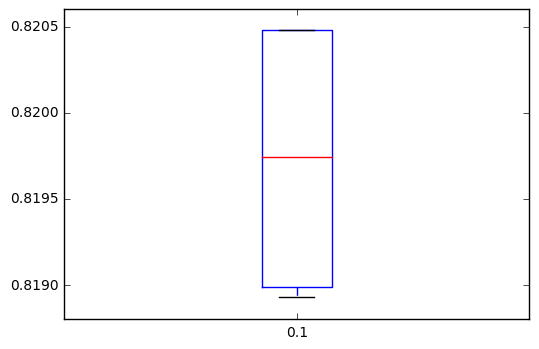

In [25]:
# exclude = [ 1,2,14,19,20,24,25,28 ]
# include = [i for i in range(30) if i not in exclude]
# tX_excluded = np.copy(tX[:,include])
# tX_test_excluded = np.copy(tX_test[:,include])

poly_degree = 5

tX_train,tX_test_proc = feature_process(tX, tX_test, poly_degree)
y_train = np.array([1 if i==1 else 0 for i in y])

N = tX_train.shape[0]
print(N)
D = tX_train.shape[1]
print(D)

seed = 1
k_fold = 4
k_indices = build_k_indices(N, k_fold, seed)

N_fold = N * (k_fold-1) / k_fold
N_test = N / k_fold

max_iters = 50
# batch_size = 1000

max_acc = 0
opt_gamma = 0
acc_avg = []
acc = []
ind=0

ws=np.zeros( (D, k_fold) )

lambda_= 1
# gamma_range = np.linspace(0.001, 0.0001, 10)
# gamma_range = np.logspace(0, -1, 5)
gamma_range=[ 0.1 ]
for gamma in gamma_range:
    acc.append([])
    for k in range(k_fold):
        yTr=np.zeros( (N_fold,1) )
        xTr=np.zeros( (N_fold,D) )
        st_ind=0
        for i in range(k_fold):
            if i==k:
                yTe = y_train[k_indices[i]]
                xTe = tX_train[k_indices[i]]
            else:
                yTr[st_ind:st_ind+N/k_fold,0] = y_train[k_indices[i]]
                xTr[st_ind:st_ind+N/k_fold] = tX_train[k_indices[i]]
                st_ind = st_ind + N/k_fold

        ## Logistic regression
        loss, w = logistic_regression_newton(yTr, xTr, gamma, lambda_, max_iters)
        y_est = sigmoid(np.dot(xTe,w))
        y_label = [0 if i<0.5 else 1 for i in y_est]
        ws[:,k:k+1] = w
        corr = [True if i==yTe[ind] else False for ind, i in enumerate(y_label)]
        acc[ind].append(sum(corr)/N_test)
        print("Fold: {f}, Accuracy: {acc}, Loss:{loss}".format(f=k, acc=acc[ind][k], loss=loss))
    acc_avg.append(sum(acc[ind])/k_fold)
    print("Gamma: {gamma}, Average Accuracy: {acc}".format(gamma=gamma, acc=acc_avg[ind]))    
    if acc_avg[ind]>max_acc:
        max_acc = acc_avg[ind]
        opt_gamma = gamma
    ind=ind+1
print("Maximum Accuracy: {max_acc}, Optimal Gamma: {opt_gamma}".format(max_acc=max_acc, opt_gamma=opt_gamma))         
plt.boxplot(acc,labels = gamma_range);

weights=np.zeros([D,1])
for d in range(D):
    weights[d,0] = sum(ws[d,:])/k_fold  

## Generate predictions and save ouput in csv format for submission:

In [ ]:
OUTPUT_PATH = '/home/acy/PCML/projects/project1/predictions.csv' # TODO: fill in desired name of output file for submission
y_est = sigmoid(np.dot(tX_test_proc,weights))
y_pred = np.array([-1 if i<0.5 else 1 for i in y_est])
#y_pred = predict_labels(weights, tX_test_proc)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)